# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

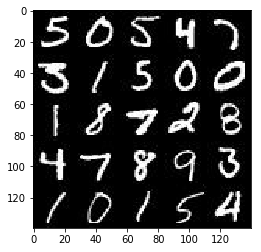

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

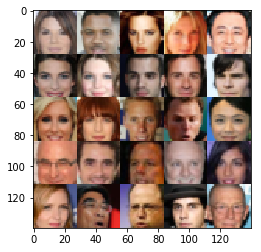

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    z_data = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, (None), name="learning_rate")
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(images, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(images, 256, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        flat = tf.reshape(x, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1, 4,4,512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        #x = tf.nn.dropout(x, keep_prob=0.95)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.9
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*alpha))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):

# TODO: Build Model
    
    #out_channel_dim = 3 if data_image_mode=="RGB" else 1    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
        # TODO: Train Model
                steps+=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, lr: learning_rate, input_real: batch_images})
            
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Step: {:.4f}".format(steps))
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0222... Generator Loss: 0.2961 Step: 100.0000
Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 1.4507 Step: 200.0000


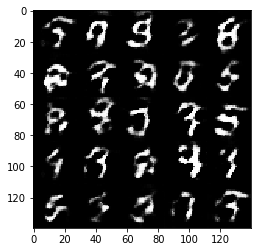

Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.5505 Step: 300.0000
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.8270 Step: 400.0000


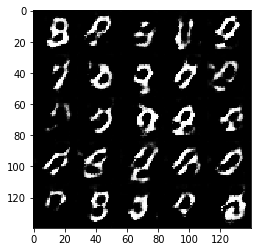

Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.8681 Step: 500.0000
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.6858 Step: 600.0000


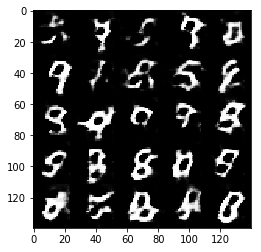

Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.8283 Step: 700.0000
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.9682 Step: 800.0000


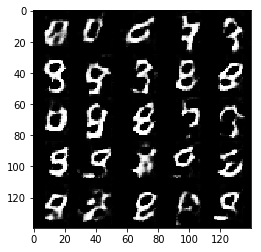

Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 0.6326 Step: 900.0000
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.9280 Step: 1000.0000


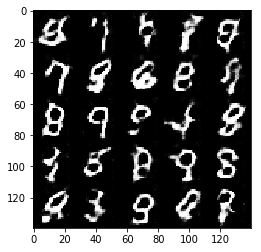

Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 1.0250 Step: 1100.0000
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.7345 Step: 1200.0000


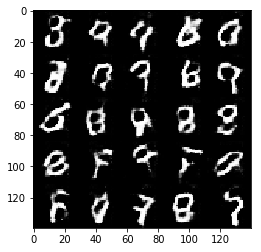

Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.8024 Step: 1300.0000
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.6599 Step: 1400.0000


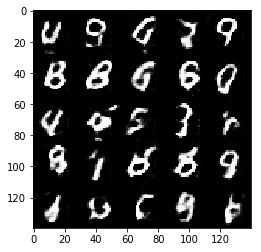

Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 1.2732 Step: 1500.0000
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.7603 Step: 1600.0000


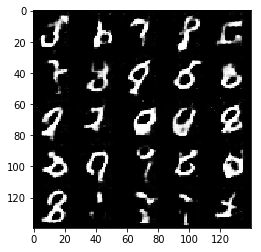

Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.9908 Step: 1700.0000
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.6359 Step: 1800.0000


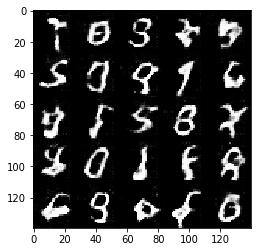

Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 1.2369 Step: 1900.0000
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.9554 Step: 2000.0000


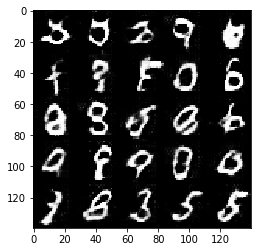

Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.6943 Step: 2100.0000
Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 0.8135 Step: 2200.0000


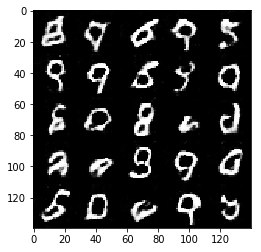

Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 1.1337 Step: 2300.0000
Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.6102 Step: 2400.0000


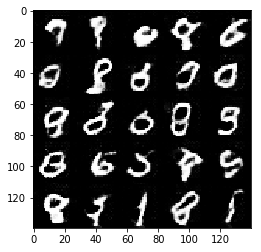

In [12]:
#l_rate = [0.01, 0.005, 0.02]
#b1 = [0.3,0.4,0.5,0.6]

batch_size = 50
z_dim = 50
learning_rate = 0.005
beta1 = 0.4#4/6

tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.4025 Step: 100.0000
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.1811 Step: 200.0000


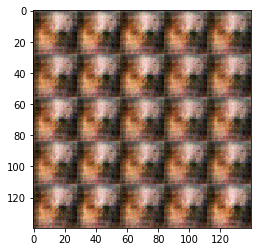

Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.6351 Step: 300.0000
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 1.0976 Step: 400.0000


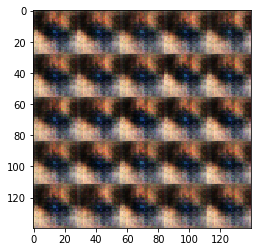

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.9483 Step: 500.0000
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.0310 Step: 600.0000


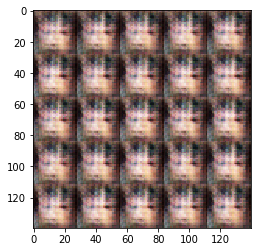

Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.1788 Step: 700.0000
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9425 Step: 800.0000


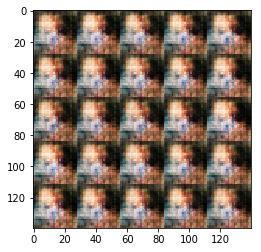

Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.2036 Step: 900.0000
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9537 Step: 1000.0000


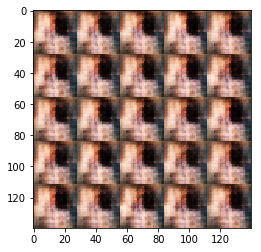

Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9027 Step: 1100.0000
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9578 Step: 1200.0000


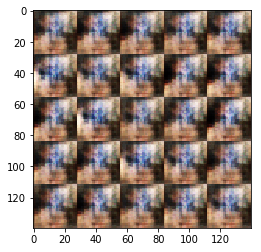

Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.1349 Step: 1300.0000
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8552 Step: 1400.0000


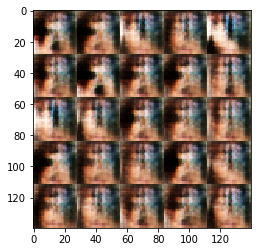

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.9768 Step: 1500.0000
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8855 Step: 1600.0000


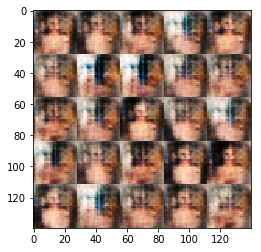

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7677 Step: 1700.0000
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.8714 Step: 1800.0000


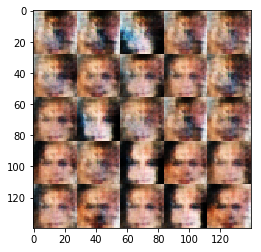

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7199 Step: 1900.0000
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8351 Step: 2000.0000


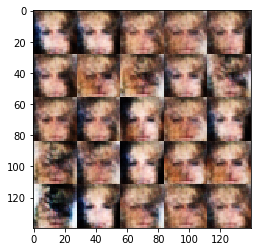

Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6771 Step: 2100.0000
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.9502 Step: 2200.0000


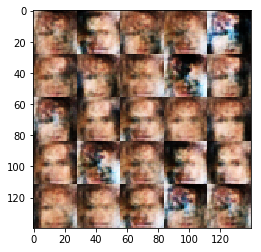

Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6590 Step: 2300.0000
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 1.1051 Step: 2400.0000


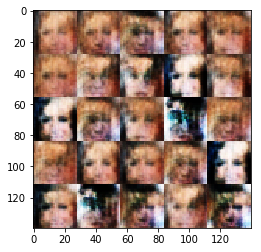

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6870 Step: 2500.0000
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.8420 Step: 2600.0000


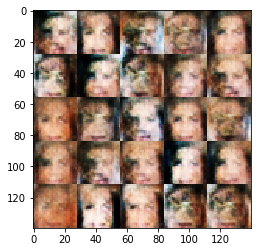

Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5995 Step: 2700.0000
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6614 Step: 2800.0000


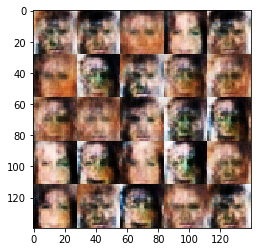

Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8037 Step: 2900.0000
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7508 Step: 3000.0000


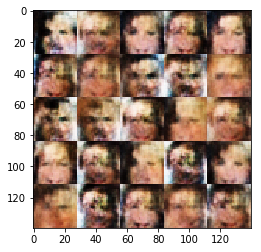

Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 1.2174 Step: 3100.0000
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5749 Step: 3200.0000


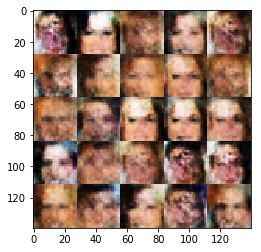

Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.4773 Step: 3300.0000
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6237 Step: 3400.0000


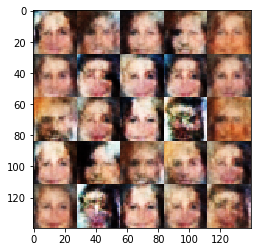

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6898 Step: 3500.0000
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7756 Step: 3600.0000


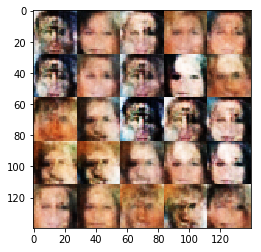

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6481 Step: 3700.0000
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6342 Step: 3800.0000


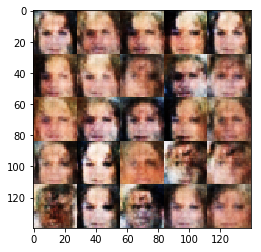

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7703 Step: 3900.0000
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8727 Step: 4000.0000


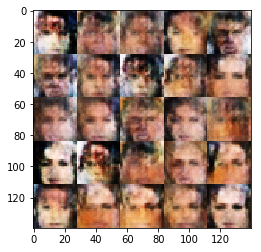

Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 1.2504 Step: 4100.0000
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6251 Step: 4200.0000


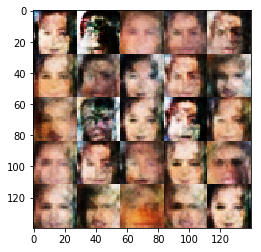

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8115 Step: 4300.0000
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6798 Step: 4400.0000


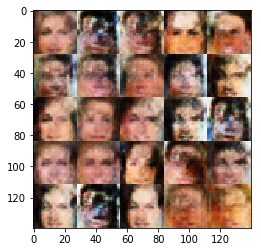

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7485 Step: 4500.0000
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8775 Step: 4600.0000


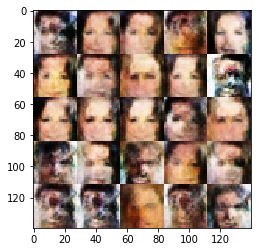

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8662 Step: 4700.0000
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6942 Step: 4800.0000


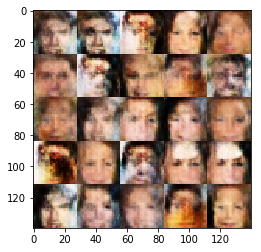

Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6951 Step: 4900.0000
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8325 Step: 5000.0000


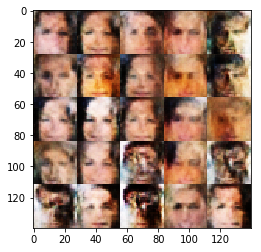

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8886 Step: 5100.0000
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.9907 Step: 5200.0000


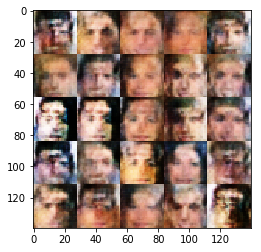

Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.9101 Step: 5300.0000
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6401 Step: 5400.0000


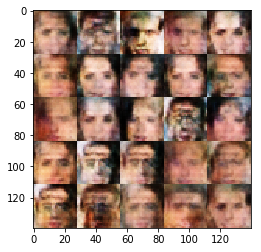

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7759 Step: 5500.0000
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7969 Step: 5600.0000


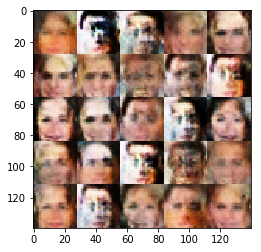

Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7353 Step: 5700.0000
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8380 Step: 5800.0000


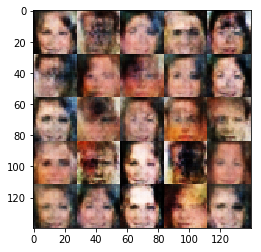

Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8220 Step: 5900.0000
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7931 Step: 6000.0000


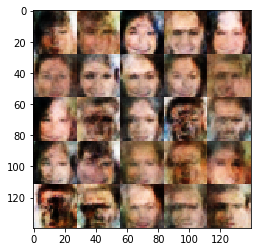

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 1.0005 Step: 6100.0000
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8659 Step: 6200.0000


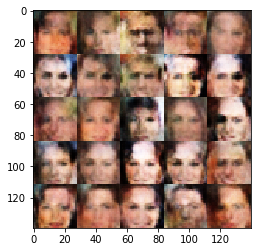

Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7241 Step: 6300.0000


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.